# Decision Tree Ensemble Starter Kit for Kaggle Mercedes Benz Manufacturing

## Imports and inits

In [2]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import xgboost as xgb
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,24 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_lijingning_zxb11b
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Import data

In [3]:
train = h2o.import_file('/Users/lijingning/Desktop/Machine_Learning/Kaggle_Mercedes_Benz_Manufacturing/train.csv')
test = h2o.import_file('/Users/lijingning/Desktop/Machine_Learning/Kaggle_Mercedes_Benz_Manufacturing/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'y'
test.columns = cols
print(train.shape)
print(test.shape)

(4209, 378)
(4209, 378)


#### Determine data types

In [4]:
def get_type_lists(frame=train, rejects=['ID', 'y']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [5]:
original_nums, cats = get_type_lists()

Numeric = ['X384', 'X89', 'X350', 'X163', 'X49', 'X79', 'X205', 'X337', 'X345', 'X343', 'X344', 'X296', 'X360', 'X36', 'X160', 'X185', 'X126', 'X44', 'X206', 'X115', 'X13', 'X54', 'X242', 'X168', 'X29', 'X159', 'X111', 'X166', 'X61', 'X313', 'X243', 'X27', 'X270', 'X118', 'X56', 'X245', 'X238', 'X203', 'X302', 'X297', 'X155', 'X251', 'X216', 'X263', 'X20', 'X104', 'X128', 'X132', 'X300', 'X103', 'X45', 'X261', 'X258', 'X317', 'X255', 'X136', 'X108', 'X235', 'X363', 'X173', 'X352', 'X354', 'X271', 'X349', 'X341', 'X222', 'X167', 'X286', 'X19', 'X325', 'X112', 'X262', 'X224', 'X68', 'X225', 'X226', 'X220', 'X117', 'X279', 'X211', 'X353', 'X367', 'X196', 'X266', 'X158', 'X32', 'X295', 'X374', 'X268', 'X377', 'X53', 'X113', 'X318', 'X109', 'X14', 'X309', 'X116', 'X276', 'X278', 'X84', 'X182', 'X264', 'X274', 'X227', 'X252', 'X85', 'X307', 'X304', 'X162', 'X210', 'X293', 'X63', 'X247', 'X197', 'X310', 'X342', 'X365', 'X157', 'X290', 'X83', 'X366', 'X179', 'X329', 'X348', 'X50', 'X131', 'X31

## Split into to train and validation (before doing data prep!!!)

In [6]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(2936, 378)
(1273, 378)


## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [7]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [8]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'y')
    v_enc, ts_enc = target_encoder(valid, test, var, 'y')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: X8 (1/8) ...
Encoding: X4 (2/8) ...
Encoding: X2 (3/8) ...
Encoding: X3 (4/8) ...
Encoding: X1 (5/8) ...
Encoding: X5 (6/8) ...
Encoding: X6 (7/8) ...
Encoding: X0 (8/8) ...
Done.


## Principal Component Analysis

In [9]:
# convert h2o dataframe to pandas
train = h2o.as_list(train)
valid = h2o.as_list(valid)
test = h2o.as_list(test)

In [10]:
# extract numerical variables 
train_x = (train.ix[:,10:378].values).astype('int32')
train_y = train.ix[:,1].values.astype('float32')
valid_x = (train.ix[:,10:378].values).astype('int32')
valid_y = train.ix[:,1].values.astype('float32')
test_x = (train.ix[:,10:378].values).astype('int32')

In [11]:
# import packages
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import decomposition

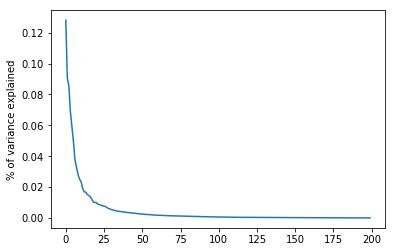

In [12]:
# principal conponent analysis to train
## PCA decomposition
pca = decomposition.PCA(n_components=200) #Finds first 200 PCs
pca.fit(train_x)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')

In [13]:
# plot reaches asymptote at around 50, which is optimal number of PCs to use. 

## PCA decomposition with optimal number of PCs
# decompose train data
pca = decomposition.PCA(n_components=50) #use first 3 PCs (update to 100 later)
pca.fit(train_x)
train_x = pd.DataFrame(pca.transform(train_x))

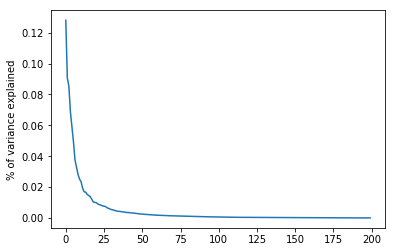

In [14]:
# principal conponent analysis to valid
## PCA decomposition
pca = decomposition.PCA(n_components=200) #Finds first 200 PCs
pca.fit(valid_x)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')

In [15]:
# plot reaches asymptote at around 50, which is optimal number of PCs to use. 

## PCA decomposition with optimal number of PCs
# decompose valid data
pca = decomposition.PCA(n_components=50) #use first 3 PCs (update to 100 later)
pca.fit(valid_x)
valid_x = pd.DataFrame(pca.transform(valid_x))

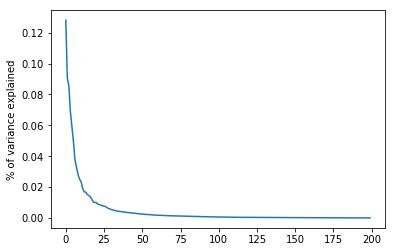

In [16]:
# principal conponent analysis to test
## PCA decomposition
pca = decomposition.PCA(n_components=200) #Finds first 200 PCs
pca.fit(test_x)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')

In [17]:
# plot reaches asymptote at around 50, which is optimal number of PCs to use. 

## PCA decomposition with optimal number of PCs
# decompose test data
pca = decomposition.PCA(n_components=50) #use first 3 PCs (update to 100 later)
pca.fit(test_x)
test_x = pd.DataFrame(pca.transform(test_x))

## Data frame process for h2o

In [18]:
# name the new columns
train_x.columns = ['X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10'
                  ,'X_11','X_12','X_13','X_14','X_15','X_16','X_17','X_18','X_19','X_20'
                  ,'X_21','X_22','X_23','X_24','X_25','X_26','X_27','X_28','X_29','X_30'
                  ,'X_31','X_32','X_33','X_34','X_35','X_36','X_37','X_38','X_39','X_40'
                  ,'X_41','X_42','X_43','X_44','X_45','X_46','X_47','X_48','X_49','X_50']
valid_x.columns = ['X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10'
                  ,'X_11','X_12','X_13','X_14','X_15','X_16','X_17','X_18','X_19','X_20'
                  ,'X_21','X_22','X_23','X_24','X_25','X_26','X_27','X_28','X_29','X_30'
                  ,'X_31','X_32','X_33','X_34','X_35','X_36','X_37','X_38','X_39','X_40'
                  ,'X_41','X_42','X_43','X_44','X_45','X_46','X_47','X_48','X_49','X_50']
test_x.columns = ['X_1','X_2','X_3','X_4','X_5','X_6','X_7','X_8','X_9','X_10'
                  ,'X_11','X_12','X_13','X_14','X_15','X_16','X_17','X_18','X_19','X_20'
                  ,'X_21','X_22','X_23','X_24','X_25','X_26','X_27','X_28','X_29','X_30'
                  ,'X_31','X_32','X_33','X_34','X_35','X_36','X_37','X_38','X_39','X_40'
                  ,'X_41','X_42','X_43','X_44','X_45','X_46','X_47','X_48','X_49','X_50']

In [19]:
# subset data
train_subset = train[['ID','y','X0','X1','X2','X3','X4','X5','X6','X8'
                      ,'X0_Tencode','X1_Tencode','X2_Tencode','X3_Tencode'
                      ,'X4_Tencode','X5_Tencode','X6_Tencode','X8_Tencode']]
valid_subset = valid[['ID','y','X0','X1','X2','X3','X4','X5','X6','X8'
                      ,'X0_Tencode','X1_Tencode','X2_Tencode','X3_Tencode'
                      ,'X4_Tencode','X5_Tencode','X6_Tencode','X8_Tencode']]
test_subset = test[['ID','y','X0','X1','X2','X3','X4','X5','X6','X8'
                      ,'X0_Tencode','X1_Tencode','X2_Tencode','X3_Tencode'
                      ,'X4_Tencode','X5_Tencode','X6_Tencode','X8_Tencode']]

In [20]:
# join data
train = train_subset.join(train_x)
valid = valid_subset.join(valid_x)
test = test_subset.join(test_x)

In [21]:
# export to csv
train.to_csv('train_new.csv', index = False)
valid.to_csv('valid_new.csv', index = False)
test.to_csv('test_new.csv', index = False)

In [22]:
# import data 
train = pd.read_csv("train_new.csv")
valid = pd.read_csv("valid_new.csv")
test = pd.read_csv("test_new.csv")

In [23]:
# convert dataframe to H2OFrame
train = h2o.H2OFrame(train)
valid = h2o.H2OFrame(valid)
test = h2o.H2OFrame(test)

#### Redefine numerics and explore

In [24]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['X_4', 'X_18', 'X_10', 'X_30', 'X_40', 'X_19', 'X_2', 'X_42', 'X_13', 'X_48', 'X8_Tencode', 'X_43', 'X0_Tencode', 'X_50', 'X_37', 'X_28', 'X_24', 'X_49', 'X3_Tencode', 'X_17', 'X_34', 'X_38', 'X_1', 'X5_Tencode', 'X_46', 'X_25', 'X_16', 'X_21', 'X_31', 'X_36', 'X_27', 'X_35', 'X_39', 'X_3', 'X6_Tencode', 'X_22', 'X_45', 'X_32', 'X_8', 'X4_Tencode', 'X_6', 'X_47', 'X2_Tencode', 'X_23', 'X_15', 'X_14', 'X_44', 'X_20', 'X_9', 'X_12', 'X_26', 'X_7', 'X_33', 'X_11', 'X_29', 'X_5', 'X1_Tencode', 'X_41']

Categorical = ['X3', 'X8', 'X5', 'X4', 'X6', 'X1', 'X0', 'X2']


In [26]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #58 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #58 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #58 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:2936
Cols:58




,X_4,X_18,X_10,X_30,X_40,X_19,X_2,X_42,X_13,X_48,X8_Tencode,X_43,X0_Tencode,X_50,X_37,X_28,X_24,X_49,X3_Tencode,X_17,X_34,X_38,X_1,X5_Tencode,X_46,X_25,X_16,X_21,X_31,X_36,X_27,X_35,X_39,X_3,X6_Tencode,X_22,X_45,X_32,X_8,X4_Tencode,X_6,X_47,X2_Tencode,X_23,X_15,X_14,X_44,X_20,X_9,X_12,X_26,X_7,X_33,X_11,X_29,X_5,X1_Tencode,X_41
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,-2.3837586838631903,-1.7357278392144853,-2.086628674850628,-1.3601414870620363,-0.9386667392603636,-1.697278488323276,-2.9988361594707813,-1.2054550180531332,-1.8359425104213003,-0.9902854046296704,96.21147058823529,-1.2536207088277207,78.54861256811984,-0.9880338877847652,-1.0307907900441118,-1.3480130618369728,-1.4531283416632315,-1.1725671052787903,96.78066406249997,-1.7496558447442874,-1.274112830288528,-1.2879295195381062,-3.300734953105372,79.93411256811986,-0.9249090574825004,-1.5209603384422348,-1.6985390221264332,-1.6478845050018482,-1.333528531163242,-1.1816333729456507,-1.2761311790468963,-1.0962966239294558,-1.1472675799646468,-3.3560484982786054,95.77492506811986,-1.3605239445941326,-1.0631793355402102,-1.3935944267176803,-2.0527656933549023,97.29961256811984,-2.4513874706286534,-0.9094660722058656,85.82285999080027,-1.468342928996493,-1.81587045983976,-1.8602946639050055,-0.9788172145666652,-1.8150404878631377,-2.0553140603856863,-2.162181979423638,-1.398020823480877,-2.736336111264768,-1.2488668529975206,-2.0967146832364127,-1.4171464196994346,-3.0327524061509488,81.57511256811986,-0.9928350285806742
mean,-3.724234462487708e-17,-1.5178830414797062e-17,-1.347087317995349e-16,2.9652929417478546e-17,7.182839392716467e-17,4.2934406030425976e-17,-1.0884034559038858e-16,1.9569849213363355e-17,4.5997277167697526e-17,-6.973452848155204e-17,100.79414844411242,-5.2109466915084557e-17,100.71619876855208,-7.401035079929175e-17,-4.401860820291148e-17,2.824346659324739e-17,-3.74049749507499e-17,-1.6883060704672714e-17,100.76277540777964,-3.9546274241408774e-17,2.630545520992955e-17,5.941427905220564e-17,9.741556519782257e-17,100.76718665731818,9.000572097524195e-17,-6.436772772774879e-17,-5.057803134644878e-17,3.7269449679189215e-17,-1.5937771935536915e-17,5.979374981257557e-17,-2.336455681706262e-17,-1.7035526635178488e-16,-6.03900610074426e-17,-5.583641188300348e-18,100.75216181449736,-1.3942162311805784e-16,3.7052609244692114e-17,-2.887704723779361e-17,-1.3877787807814457e-16,100.75429142117403,-2.656295322589486e-18,4.797594613248357e-17,100.71736220588502,3.903127820947816e-17,-3.1604493327952454e-17,6.105413483808997e-17,-4.977165598066269e-17,-4.2704013068772806e-17,-3.5236570605778894e-17,2.2314235962467288e-17,5.957690937807847e-17,-2.382534274036896e-17,4.311058888345487e-17,9.486769009248164e-19,-1.3700249702069955e-16,6.92940713489798e-17,100.76160388967831,-6.667843360785852e-17
maxs,3.7145127924420662,2.2031481565282287,2.451093793024301,2.0137537192751904,1.8295282273574123,1.6991040611920694,4.6042844449036195,1.2908304736306813,2.04685694289991,1.2526815483383604,105.51629870129872,1.3797061684754912,144.45761256811986,1.0452637564889051,1.4066861598551281,1.5373695670769667,2.136512473393339,1.299924956551407,105.47258373205736,1.8003969420999941,1.4685866413626047,1.8581649827676103,3.9548501881985283,126.30161256811984,1.4822688377829183,1.6857248776689175,1.9019919756445924,1.9026365686197269,1.4845241015605632,1.344663475050241,1.4891880306623355,1.1873534448214642,1.2803211332752742,3.3767749792506954,109.26761256811989,1.6228455391945058,1.157379300124044,1.8098770725236952,2.4493186882329163,100.75546848381576,3.8583070473797614,1.4511750980559304,139.46811256811986,1.6207965282038415,2.1614096017640763,2.1654628325644705,0.9870621801518896,1.867806040814832,3.0649993390147054,2.5628

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:1273
Cols:58




,X_4,X_18,X_10,X_30,X_40,X_19,X_2,X_42,X_13,X_48,X8_Tencode,X_43,X0_Tencode,X_50,X_37,X_28,X_24,X_49,X3_Tencode,X_17,X_34,X_38,X_1,X5_Tencode,X_46,X_25,X_16,X_21,X_31,X_36,X_27,X_35,X_39,X_3,X6_Tencode,X_22,X_45,X_32,X_8,X4_Tencode,X_6,X_47,X2_Tencode,X_23,X_15,X_14,X_44,X_20,X_9,X_12,X_26,X_7,X_33,X_11,X_29,X_5,X1_Tencode,X_41
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,-2.129097217968591,-1.735690384701586,-2.086628606686772,-1.3597488220704643,-0.9299372884010436,-1.6972748383918663,-2.9988361598085214,-1.0596619202348656,-1.8359381609533991,-0.8275960296478242,96.77333023875836,-0.8619900054735555,80.50194766300079,-0.7917958645053791,-1.0332133090330209,-1.3490842280685031,-1.0602121222197365,-1.0246926402633534,96.02551948051943,-1.7235622232052168,-1.1055409052752707,-1.2866081712671855,-3.2549491162011455,83.59807266300079,-0.8392492685727191,-1.4469523688573438,-1.5208629164457648,-1.3654874493272045,-1.3361209685537014,-0.903206620315292,-1.2615848618324328,-1.0557878456253835,-1.1039211195443255,-3.356048497199218,95.3854476630008,-1.2207346932562535,-0.9107520472206648,-1.3935568988118952,-2.0527657576250014,100.43371653543316,-2.3987991972288873,-0.8757173848421025,80.50194766300079,-1.4683135180495281,-1.7472673093052928,-1.8602946159288232,-0.9472791168896125,-1.8149822696052944,-2.0553138948735694,-2.1621795444625125,-1.271287672427175,-2.736336094272942,-1.1899778576051798,-2.0967163932684842,-1.1491259150341975,-3.0327524040719873,80.76615599633412,-1.0185133003299631
mean,-0.019706826044983066,0.0273721534161041,-0.015683218103723723,0.003645828508743467,-0.023530163946727096,0.008328958812412307,0.02183299801706953,-0.0008207223836030977,0.017166656737462566,-0.007167173420913255,100.47381775333868,0.0018810621011671024,100.47381775333851,-0.00347532818778129,0.012327654524178602,-0.007579742760047777,-0.0240638243530524,0.0059431231020159936,100.41095176328224,-0.016848301734065485,-0.009087165041094044,0.02201131168569425,-0.06655282084297713,100.4738177533386,0.0007680840133724323,-0.034000468886527566,0.014916663673077502,0.027520606878395172,0.016354907567342897,-0.006842163135858581,-0.009614994872935288,0.025002516938866962,0.004084486923038029,0.03759528834064182,100.52661593004507,-0.006670344875219031,-0.017826414322858246,0.01820311114784823,-0.016131169508042803,100.46781674626017,0.005335521828081183,0.006295689131744918,100.558782057896,-0.010125850854498823,0.018216747601556005,0.019532705766148597,0.0025376125213205734,0.007180239971678405,-0.033689744758162395,0.013364539786646597,-0.015318352315128608,-0.006032871962032157,0.01146700119962493,0.07863742879748085,-0.004219246721986544,0.033456086589362694,100.47794608766634,0.004289759512767932
maxs,3.7145127960960367,2.2030932201288698,2.4510943335173705,2.0093059898694343,1.8356449965241968,1.5777590268527735,4.598970071792946,1.384945267285315,2.0468587926172144,1.3013025525229267,104.3848226630008,1.3996493054757575,115.57507266300081,0.8416492518162091,1.4014713503533869,1.3661500503273662,2.1364556053480666,1.0878042645875867,103.63278253954404,1.8003906062902506,1.1940154688218092,1.6715567852606381,3.9298626116074855,108.10357266300078,1.3228904972613351,1.416286501225169,1.890021517409756,1.861392299272365,1.4823275193396768,1.3537766834096188,1.105862387409014,1.1829311838718173,1.0634359862433735,3.3391006673716452,105.76323932966744,1.6227382071692036,1.1370741072171802,1.7025211946890124,2.4493186482378646,129.00507266300082,3.3895118349729816,1.3824780604759062,115.51557266300081,1.6207262702876488,1.7012192560235446,2.1654623664547468,1.0338524310503874,1.8677283952157993,3.063608017321441,2.19983491274218,1.9512337733039475,2.9251133149827204,1.3480757656559408,2.5832849996

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:4209
Cols:58




,X_4,X_18,X_10,X_30,X_40,X_19,X_2,X_42,X_13,X_48,X8_Tencode,X_43,X0_Tencode,X_50,X_37,X_28,X_24,X_49,X3_Tencode,X_17,X_34,X_38,X_1,X5_Tencode,X_46,X_25,X_16,X_21,X_31,X_36,X_27,X_35,X_39,X_3,X6_Tencode,X_22,X_45,X_32,X_8,X4_Tencode,X_6,X_47,X2_Tencode,X_23,X_15,X_14,X_44,X_20,X_9,X_12,X_26,X_7,X_33,X_11,X_29,X_5,X1_Tencode,X_41
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,-2.383758690711808,-1.7356861744278862,-2.0866287008146416,-1.360886950332766,-0.8793063213897222,-1.697185390870717,-2.9988361588923893,-1.2635415974233095,-1.8359348036960519,-0.9671492714543344,96.77333023875836,-1.1684207202576888,80.50194766300079,-1.0644207272986463,-1.0345058860467011,-1.3487554877812875,-1.4533195515147321,-1.0657830752853368,96.02551948051943,-1.7496634709824392,-1.2712245199630046,-1.2937034613123075,-3.3007349531965184,83.59807266300079,-0.9385075971361284,-1.5211095311247358,-1.6985206734240115,-1.6477475290141215,-1.3412278069261578,-1.1681233998647258,-1.275957131059894,-1.0877002333754,-1.1583595923155663,-3.356048498148746,95.3854476630008,-1.3605593032463734,-0.9562835842907652,-1.394330515577971,-2.0527657583716645,100.43371653543316,-2.4513874806718845,-1.0741055295478894,80.50194766300079,-1.468383218612161,-1.8158724283941288,-1.8602947970435149,-0.9661270835002211,-1.8149541429096137,-2.0553140159143233,-2.1621847923423063,-1.3980009265821252,-2.736336067522389,-1.2443038103390778,-2.0967165124326193,-1.4165877020878392,-3.032752402019076,80.76615599633412,-0.9762300448909852
mean,1.7401444868392346e-16,4.336808689942018e-17,5.383402599569431e-17,-8.414764111203121e-17,-9.066640667410031e-17,5.898059818321144e-17,-7.90247858470372e-17,-5.2583805365546965e-18,1.1928934402771763e-16,-9.09611741397448e-17,100.59062558636502,-4.412702842016003e-17,100.81740066779545,3.319691526879054e-17,4.7596475372113645e-17,-5.023921816754706e-17,2.3115190317390955e-16,-1.622597489584019e-17,100.31799485881525,-2.3174821436877657e-17,4.788107844239109e-17,-1.1655173354219173e-17,-3.251522315284028e-16,100.46089834599667,3.128600893978484e-17,8.864708012784606e-17,-3.7486290113686316e-17,-9.540979117872439e-18,6.906367838732663e-17,2.961227183601034e-17,2.3771132631744685e-17,-3.121147004042646e-17,-1.0055975149803054e-17,-1.5406512871019018e-16,100.54393263645711,-2.273436430430542e-18,8.942635043932001e-17,-4.391018798566293e-18,2.8254308614972246e-16,100.45152638023364,1.2696007439805257e-16,-3.65376132127615e-17,100.78544909343121,1.3552527156068805e-18,1.679158114636925e-17,7.092037460770806e-17,-8.438481033726242e-17,-9.929936647251614e-17,-5.2692225582795515e-17,-5.74356100874196e-17,-7.860465750519907e-18,7.55959964765518e-17,-3.4484405348617075e-17,-1.509751525186065e-17,-6.223998096424599e-17,2.7803009460675154e-17,100.44034364082147,1.439278383974507e-17
maxs,3.7145127926566692,2.2030989628421227,2.4510936670969854,2.010729092928083,1.8878517054928252,1.699180518949134,4.604284444204396,1.2657013937173756,2.046860932646965,1.2322395039648055,104.3848226630008,1.378715013094899,115.57507266300081,1.2448404705767138,1.3958466495300434,1.5369548858795277,2.1365399360320936,1.1189072249934886,103.63278253954404,1.8003922965602168,1.4728151214212528,1.8436896392234128,3.9548501881945364,108.10357266300078,1.528589669698179,1.6856157722338083,1.9019845631882681,1.9027420775611648,1.4861004895105276,1.3504094897530672,1.4899075971933282,1.1847564424176242,1.267901741823501,3.3767749781650394,105.76323932966744,1.6228002289080004,1.1717427720953952,1.81185709572872,2.4493186804809657,129.00507266300082,3.8583070411864213,1.5723328504673948,115.51557266300081,1.6208232132496097,2.1614224520000604,2.1654647380010017,0.990382973526947,1.8677621782531162,3.0649996986256483,2.562880552509989

## Create combination features

In [27]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [28]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: X_4 (1/58) ...
Combining: X_18 (2/58) ...
Combining: X_10 (3/58) ...
Combining: X_30 (4/58) ...
Combining: X_40 (5/58) ...
Combining: X_19 (6/58) ...
Combining: X_2 (7/58) ...
Combining: X_42 (8/58) ...
Combining: X_13 (9/58) ...
Combining: X_48 (10/58) ...
Combining: X8_Tencode (11/58) ...
Combining: X_43 (12/58) ...
Combining: X0_Tencode (13/58) ...
Combining: X_50 (14/58) ...
Combining: X_37 (15/58) ...
Combining: X_28 (16/58) ...
Combining: X_24 (17/58) ...
Combining: X_49 (18/58) ...
Combining: X3_Tencode (19/58) ...
Combining: X_17 (20/58) ...
Combining: X_34 (21/58) ...
Combining: X_38 (22/58) ...
Combining: X_1 (23/58) ...
Combining: X5_Tencode (24/58) ...
Combining: X_46 (25/58) ...
Combining: X_25 (26/58) ...
Combining: X_16 (27/58) ...
Combining: X_21 (28/58) ...
Combining: X_31 (29/58) ...
Combining: X_36 (30/58) ...
Combining: X_27 (31/58) ...
Combining: X_35 (32/58) ...
Combining: X_39 (33/58) ...
Combining: X_3 (34/58) ...
Combining: X6_Tencode (35/58) ...
Com

#### Redefine numerics and explore

In [29]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['X_24|X_12', 'X_47|X_9', 'X_40|X_36', 'X_49|X_5', 'X_18|X_35', 'X_36|X2_Tencode', 'X_17|X_41', 'X_30|X4_Tencode', 'X_39|X_45', 'X_22|X_23', 'X_13|X2_Tencode', 'X8_Tencode|X_17', 'X_40|X_47', 'X_34|X_12', 'X_48|X_45', 'X_48|X_20', 'X_18|X_2', 'X_35|X_47', 'X_43|X_7', 'X_25|X_8', 'X_38|X_33', 'X3_Tencode|X_46', 'X_40|X_49', 'X_34|X_44', 'X_40|X_24', 'X_14|X_7', 'X_46|X_15', 'X_34|X_38', 'X_46|X_7', 'X_35|X_32', 'X_10|X_43', 'X_48|X_34', 'X_40|X4_Tencode', 'X_4|X_7', 'X_16|X_9', 'X_28|X_29', 'X_47', 'X_16|X_31', 'X_48|X_38', 'X_40|X_25', 'X3_Tencode|X_17', 'X6_Tencode|X_8', 'X_2|X_17', 'X_40|X_48', 'X_48|X_50', 'X_19|X2_Tencode', 'X_16|X_11', 'X_19|X_42', 'X_1|X_16', 'X_21|X_9', 'X6_Tencode|X_23', 'X_42|X_50', 'X_42|X_43', 'X_27|X_8', 'X_34|X_25', 'X_21', 'X_48|X_9', 'X_6|X_15', 'X_4|X4_Tencode', 'X_37|X_22', 'X6_Tencode|X_33', 'X3_Tencode|X5_Tencode', 'X_3|X_7', 'X_2|X0_Tencode', 'X0_Tencode|X_14', 'X4_Tencode|X_11', 'X_19|X_31', 'X_27|X_47', 'X_45', 'X_32', 'X_28|X_7', 'X_23|

In [245]:
train

ID y X0 X1 X2 X3 X4 X5 X6 X8 X0_Tencode X1_Tencode X2_Tencode X3_Tencode X4_Tencode X5_Tencode X6_Tencode X8_Tencode X_1 X_2 X_3 X_4 X_5 X_6 X_7 X_8 X_9 X_10 X_11 X_12 X_13 X_14 X_15 X_16 X_17 X_18 X_19 X_20 X_21 X_22 X_23 X_24 X_25 X_26 X_27 X_28 X_29 X_30 X_31 X_32 X_33 X_34 X_35 X_36 X_37 X_38 X_39 X_40 X_41 X_42 X_43 X_44 X_45 X_46 X_47 X_48 X_49 X_50 X_25|X6_Tencode X_25|X_11 X_25|X_19 X_25|X_32 X_25|X_16 X_25|X1_Tencode X_25|X_31 X_25|X_41 X_25|X_20 X_25|X2_Tencode X_25|X_22 X_25|X_38 X_25|X_7 X_25|X_39 X_25|X_1 X_25|X_33 X_25|X_5 X_25|X_30 X_25|X8_Tencode X_25|X_46 X_25|X_37 X_25|X_15 X_25|X_8 X_25|X_27 X_25|X_13 X_25|X_2 X_25|X_14 X_25|X0_Tencode X_25|X_36 X_25|X_26 X_25|X_23 X_25|X_4 X_25|X3_Tencode X_25|X4_Tencode X_25|X_12 X_25|X5_Tencode X_25|X_21 X_25|X_40 X_25|X_44 X_25|X_50 X_25|X_3 X_25|X_43 X_25|X_6 X_25|X_34 X_25|X_29 X_25|X_28 X_25|X_35 X_25|X_47 X_25|X_42 X_25|X_48 X_25|X_18 X_25|X_17 X_25|X_10 X_25|X_45 X_25|X_9 X_25|X_24 X_25|X_49 X6_Tencode|X_11 X6_Tencode|X_19 X6_Tencode|X_32 X6_Tencode|X_16 X6_Tencode|X1_Tencode X6_Tencode|X_31 X6_Tencode|X_41 X6_Tencode|X_20 X6_Tencode|X2_Tencode X6_Tencode|X_22 X6_Tencode|X_38 X6_Tencode|X_7 X6_Tencode|X_39 X6_Tencode|X_1 X6_Tencode|X_33 X6_Tencode|X_5 X6_Tencode|X_30 X6_Tencode|X8_Tencode X6_Tencode|X_46 X6_Tencode|X_37 X6_Tencode|X_15 X6_Tencode|X_8 X6_Tencode|X_27 X6_Tencode|X_13 X6_Tencode|X_2 X6_Tencode|X_14 X6_Tencode|X0_Tencode X6_Tencode|X_36 X6_Tencode|X_26 X6_Tencode|X_23 X6_Tencode|X_4 X6_Tencode|X3_Tencode X6_Tencode|X4_Tencode X6_Tencode|X_12 X6_Tencode|X5_Tencode X6_Tencode|X_21 X6_Tencode|X_40 X6_Tencode|X_44 X6_Tencode|X_50 X6_Tencode|X_3 X6_Tencode|X_43 X6_Tencode|X_6 X6_Tencode|X_34 X6_Tencode|X_29 X6_Tencode|X_28 X6_Tencode|X_35 X6_Tencode|X_47 X6_Tencode|X_42 X6_Tencode|X_48 X6_Tencode|X_18 X6_Tencode|X_17 X6_Tencode|X_10 X6_Tencode|X_45 X6_Tencode|X_9 X6_Tencode|X_24 X6_Tencode|X_49 X_11|X_19 X_11|X_32 X_11|X_16 X_11|X1_Tencode X_11|X_31 X_11|X_41 X_11|X_20 X_11|X2_Tencode X_11|X_22 X_11|X_38 X_11|X_7 X_11|X_39 X_11|X_1 X_11|X_33 X_11|X_5 X_11|X_30 X_11|X8_Tencode X_11|X_46 X_11|X_37 X_11|X_15 X_11|X_8 X_11|X_27 X_11|X_13 X_11|X_2 X_11|X_14 X_11|X0_Tencode X_11|X_36 X_11|X_26 X_11|X_23 X_11|X_4 X_11|X3_Tencode X_11|X4_Tencode X_11|X_12 X_11|X5_Tencode X_11|X_21 X_11|X_40 X_11|X_44 X_11|X_50 X_11|X_3 X_11|X_43 X_11|X_6 X_11|X_34 X_11|X_29 X_11|X_28 X_11|X_35 X_11|X_47 X_11|X_42 X_11|X_48 X_11|X_18 X_11|X_17 X_11|X_10 X_11|X_45 X_11|X_9 X_11|X_24 X_11|X_49 X_19|X_32 X_19|X_16 X_19|X1_Tencode X_19|X_31 X_19|X_41 X_19|X_20 X_19|X2_Tencode X_19|X_22 X_19|X_38 X_19|X_7 X_19|X_39 X_19|X_1 X_19|X_33 X_19|X_5 X_19|X_30 X_19|X8_Tencode X_19|X_46 X_19|X_37 X_19|X_15 X_19|X_8 X_19|X_27 X_19|X_13 X_19|X_2 X_19|X_14 X_19|X0_Tencode X_19|X_36 X_19|X_26 X_19|X_23 X_19|X_4 X_19|X3_Tencode X_19|X4_Tencode X_19|X_12 X_19|X5_Tencode X_19|X_21 X_19|X_40 X_19|X_44 X_19|X_50 X_19|X_3 X_19|X_43 X_19|X_6 X_19|X_34 X_19|X_29 X_19|X_28 X_19|X_35 X_19|X_47 X_19|X_42 X_19|X_48 X_19|X_18 X_19|X_17 X_19|X_10 X_19|X_45 X_19|X_9 X_19|X_24 X_19|X_49 X_32|X_16 X_32|X1_Tencode X_32|X_31 X_32|X_41 X_32|X_20 X_32|X2_Tencode X_32|X_22 X_32|X_38 X_32|X_7 X_32|X_39 X_32|X_1 X_32|X_33 X_32|X_5 X_32|X_30 X_32|X8_Tencode X_32|X_46 X_32|X_37 X_32|X_15 X_32|X_8 X_32|X_27 X_32|X_13 X_32|X_2 X_32|X_14 X_32|X0_Tencode X_32|X_36 X_32|X_26 X_32|X_23 X_32|X_4 X_32|X3_Tencode X_32|X4_Tencode X_32|X_12 X_32|X5_Tencode X_32|X_21 X_32|X_40 X_32|X_44 X_32|X_50 X_32|X_3 X_32|X_43 X_32|X_6 X_32|X_34 X_32|X_29 X_32|X_28 X_32|X_35 X_32|X_47 X_32|X_42 X_32|X_48 X_32|X_18 X_32|X_17 X_32|X_10 X_32|X_45 X_32|X_9 X_32|X_24 X_32|X_49 X_16|X1_Tencode X_16|X_31 X_16|X_41 X_16|X_20 X_16|X2_Tencode X_16|X_22 X_16|X_38 X_16|X_7 X_16|X_39 X_16|X_1 X_16|X_33 X_16|X_5 X_16|X_30 X_16|X8_Tencode X_16|X_46 X_16|X_37 X_16|X_15 X_16|X_8 X_16|X_27 X_16|X_13 X_16|X_2 X_16|X_14 X_16|X0_Tencode X_16|X_36 X_16|X_26 X_16|X_23 X_16|X_4 X_16|X3_Tencode X_16|X4_Tencode X_16|X_12 X_16|X5_Tencode X_16|X_21 X_16|X_40 X_16|X_44 X_16|X_50

In [246]:
test

ID y X0 X1 X2 X3 X4 X5 X6 X8 X0_Tencode X1_Tencode X2_Tencode X3_Tencode X4_Tencode X5_Tencode X6_Tencode X8_Tencode X_1 X_2 X_3 X_4 X_5 X_6 X_7 X_8 X_9 X_10 X_11 X_12 X_13 X_14 X_15 X_16 X_17 X_18 X_19 X_20 X_21 X_22 X_23 X_24 X_25 X_26 X_27 X_28 X_29 X_30 X_31 X_32 X_33 X_34 X_35 X_36 X_37 X_38 X_39 X_40 X_41 X_42 X_43 X_44 X_45 X_46 X_47 X_48 X_49 X_50 X_25|X6_Tencode X_25|X_11 X_25|X_19 X_25|X_32 X_25|X_16 X_25|X1_Tencode X_25|X_31 X_25|X_41 X_25|X_20 X_25|X2_Tencode X_25|X_22 X_25|X_38 X_25|X_7 X_25|X_39 X_25|X_1 X_25|X_33 X_25|X_5 X_25|X_30 X_25|X8_Tencode X_25|X_46 X_25|X_37 X_25|X_15 X_25|X_8 X_25|X_27 X_25|X_13 X_25|X_2 X_25|X_14 X_25|X0_Tencode X_25|X_36 X_25|X_26 X_25|X_23 X_25|X_4 X_25|X3_Tencode X_25|X4_Tencode X_25|X_12 X_25|X5_Tencode X_25|X_21 X_25|X_40 X_25|X_44 X_25|X_50 X_25|X_3 X_25|X_43 X_25|X_6 X_25|X_34 X_25|X_29 X_25|X_28 X_25|X_35 X_25|X_47 X_25|X_42 X_25|X_48 X_25|X_18 X_25|X_17 X_25|X_10 X_25|X_45 X_25|X_9 X_25|X_24 X_25|X_49 X6_Tencode|X_11 X6_Tencode|X_19 X6_Tencode|X_32 X6_Tencode|X_16 X6_Tencode|X1_Tencode X6_Tencode|X_31 X6_Tencode|X_41 X6_Tencode|X_20 X6_Tencode|X2_Tencode X6_Tencode|X_22 X6_Tencode|X_38 X6_Tencode|X_7 X6_Tencode|X_39 X6_Tencode|X_1 X6_Tencode|X_33 X6_Tencode|X_5 X6_Tencode|X_30 X6_Tencode|X8_Tencode X6_Tencode|X_46 X6_Tencode|X_37 X6_Tencode|X_15 X6_Tencode|X_8 X6_Tencode|X_27 X6_Tencode|X_13 X6_Tencode|X_2 X6_Tencode|X_14 X6_Tencode|X0_Tencode X6_Tencode|X_36 X6_Tencode|X_26 X6_Tencode|X_23 X6_Tencode|X_4 X6_Tencode|X3_Tencode X6_Tencode|X4_Tencode X6_Tencode|X_12 X6_Tencode|X5_Tencode X6_Tencode|X_21 X6_Tencode|X_40 X6_Tencode|X_44 X6_Tencode|X_50 X6_Tencode|X_3 X6_Tencode|X_43 X6_Tencode|X_6 X6_Tencode|X_34 X6_Tencode|X_29 X6_Tencode|X_28 X6_Tencode|X_35 X6_Tencode|X_47 X6_Tencode|X_42 X6_Tencode|X_48 X6_Tencode|X_18 X6_Tencode|X_17 X6_Tencode|X_10 X6_Tencode|X_45 X6_Tencode|X_9 X6_Tencode|X_24 X6_Tencode|X_49 X_11|X_19 X_11|X_32 X_11|X_16 X_11|X1_Tencode X_11|X_31 X_11|X_41 X_11|X_20 X_11|X2_Tencode X_11|X_22 X_11|X_38 X_11|X_7 X_11|X_39 X_11|X_1 X_11|X_33 X_11|X_5 X_11|X_30 X_11|X8_Tencode X_11|X_46 X_11|X_37 X_11|X_15 X_11|X_8 X_11|X_27 X_11|X_13 X_11|X_2 X_11|X_14 X_11|X0_Tencode X_11|X_36 X_11|X_26 X_11|X_23 X_11|X_4 X_11|X3_Tencode X_11|X4_Tencode X_11|X_12 X_11|X5_Tencode X_11|X_21 X_11|X_40 X_11|X_44 X_11|X_50 X_11|X_3 X_11|X_43 X_11|X_6 X_11|X_34 X_11|X_29 X_11|X_28 X_11|X_35 X_11|X_47 X_11|X_42 X_11|X_48 X_11|X_18 X_11|X_17 X_11|X_10 X_11|X_45 X_11|X_9 X_11|X_24 X_11|X_49 X_19|X_32 X_19|X_16 X_19|X1_Tencode X_19|X_31 X_19|X_41 X_19|X_20 X_19|X2_Tencode X_19|X_22 X_19|X_38 X_19|X_7 X_19|X_39 X_19|X_1 X_19|X_33 X_19|X_5 X_19|X_30 X_19|X8_Tencode X_19|X_46 X_19|X_37 X_19|X_15 X_19|X_8 X_19|X_27 X_19|X_13 X_19|X_2 X_19|X_14 X_19|X0_Tencode X_19|X_36 X_19|X_26 X_19|X_23 X_19|X_4 X_19|X3_Tencode X_19|X4_Tencode X_19|X_12 X_19|X5_Tencode X_19|X_21 X_19|X_40 X_19|X_44 X_19|X_50 X_19|X_3 X_19|X_43 X_19|X_6 X_19|X_34 X_19|X_29 X_19|X_28 X_19|X_35 X_19|X_47 X_19|X_42 X_19|X_48 X_19|X_18 X_19|X_17 X_19|X_10 X_19|X_45 X_19|X_9 X_19|X_24 X_19|X_49 X_32|X_16 X_32|X1_Tencode X_32|X_31 X_32|X_41 X_32|X_20 X_32|X2_Tencode X_32|X_22 X_32|X_38 X_32|X_7 X_32|X_39 X_32|X_1 X_32|X_33 X_32|X_5 X_32|X_30 X_32|X8_Tencode X_32|X_46 X_32|X_37 X_32|X_15 X_32|X_8 X_32|X_27 X_32|X_13 X_32|X_2 X_32|X_14 X_32|X0_Tencode X_32|X_36 X_32|X_26 X_32|X_23 X_32|X_4 X_32|X3_Tencode X_32|X4_Tencode X_32|X_12 X_32|X5_Tencode X_32|X_21 X_32|X_40 X_32|X_44 X_32|X_50 X_32|X_3 X_32|X_43 X_32|X_6 X_32|X_34 X_32|X_29 X_32|X_28 X_32|X_35 X_32|X_47 X_32|X_42 X_32|X_48 X_32|X_18 X_32|X_17 X_32|X_10 X_32|X_45 X_32|X_9 X_32|X_24 X_32|X_49 X_16|X1_Tencode X_16|X_31 X_16|X_41 X_16|X_20 X_16|X2_Tencode X_16|X_22 X_16|X_38 X_16|X_7 X_16|X_39 X_16|X_1 X_16|X_33 X_16|X_5 X_16|X_30 X_16|X8_Tencode X_16|X_46 X_16|X_37 X_16|X_15 X_16|X_8 X_16|X_27 X_16|X_13 X_16|X_2 X_16|X_14 X_16|X0_Tencode X_16|X_36 X_16|X_26 X_16|X_23 X_16|X_4 X_16|X3_Tencode X_16|X4_Tencode X_16|X_12 X_16|X5_Tencode X_16|X_21 X_16|X_40 X_16|X_44 X_16|X_50

In [247]:
valid

ID y X0 X1 X2 X3 X4 X5 X6 X8 X0_Tencode X1_Tencode X2_Tencode X3_Tencode X4_Tencode X5_Tencode X6_Tencode X8_Tencode X_1 X_2 X_3 X_4 X_5 X_6 X_7 X_8 X_9 X_10 X_11 X_12 X_13 X_14 X_15 X_16 X_17 X_18 X_19 X_20 X_21 X_22 X_23 X_24 X_25 X_26 X_27 X_28 X_29 X_30 X_31 X_32 X_33 X_34 X_35 X_36 X_37 X_38 X_39 X_40 X_41 X_42 X_43 X_44 X_45 X_46 X_47 X_48 X_49 X_50 X_25|X6_Tencode X_25|X_11 X_25|X_19 X_25|X_32 X_25|X_16 X_25|X1_Tencode X_25|X_31 X_25|X_41 X_25|X_20 X_25|X2_Tencode X_25|X_22 X_25|X_38 X_25|X_7 X_25|X_39 X_25|X_1 X_25|X_33 X_25|X_5 X_25|X_30 X_25|X8_Tencode X_25|X_46 X_25|X_37 X_25|X_15 X_25|X_8 X_25|X_27 X_25|X_13 X_25|X_2 X_25|X_14 X_25|X0_Tencode X_25|X_36 X_25|X_26 X_25|X_23 X_25|X_4 X_25|X3_Tencode X_25|X4_Tencode X_25|X_12 X_25|X5_Tencode X_25|X_21 X_25|X_40 X_25|X_44 X_25|X_50 X_25|X_3 X_25|X_43 X_25|X_6 X_25|X_34 X_25|X_29 X_25|X_28 X_25|X_35 X_25|X_47 X_25|X_42 X_25|X_48 X_25|X_18 X_25|X_17 X_25|X_10 X_25|X_45 X_25|X_9 X_25|X_24 X_25|X_49 X6_Tencode|X_11 X6_Tencode|X_19 X6_Tencode|X_32 X6_Tencode|X_16 X6_Tencode|X1_Tencode X6_Tencode|X_31 X6_Tencode|X_41 X6_Tencode|X_20 X6_Tencode|X2_Tencode X6_Tencode|X_22 X6_Tencode|X_38 X6_Tencode|X_7 X6_Tencode|X_39 X6_Tencode|X_1 X6_Tencode|X_33 X6_Tencode|X_5 X6_Tencode|X_30 X6_Tencode|X8_Tencode X6_Tencode|X_46 X6_Tencode|X_37 X6_Tencode|X_15 X6_Tencode|X_8 X6_Tencode|X_27 X6_Tencode|X_13 X6_Tencode|X_2 X6_Tencode|X_14 X6_Tencode|X0_Tencode X6_Tencode|X_36 X6_Tencode|X_26 X6_Tencode|X_23 X6_Tencode|X_4 X6_Tencode|X3_Tencode X6_Tencode|X4_Tencode X6_Tencode|X_12 X6_Tencode|X5_Tencode X6_Tencode|X_21 X6_Tencode|X_40 X6_Tencode|X_44 X6_Tencode|X_50 X6_Tencode|X_3 X6_Tencode|X_43 X6_Tencode|X_6 X6_Tencode|X_34 X6_Tencode|X_29 X6_Tencode|X_28 X6_Tencode|X_35 X6_Tencode|X_47 X6_Tencode|X_42 X6_Tencode|X_48 X6_Tencode|X_18 X6_Tencode|X_17 X6_Tencode|X_10 X6_Tencode|X_45 X6_Tencode|X_9 X6_Tencode|X_24 X6_Tencode|X_49 X_11|X_19 X_11|X_32 X_11|X_16 X_11|X1_Tencode X_11|X_31 X_11|X_41 X_11|X_20 X_11|X2_Tencode X_11|X_22 X_11|X_38 X_11|X_7 X_11|X_39 X_11|X_1 X_11|X_33 X_11|X_5 X_11|X_30 X_11|X8_Tencode X_11|X_46 X_11|X_37 X_11|X_15 X_11|X_8 X_11|X_27 X_11|X_13 X_11|X_2 X_11|X_14 X_11|X0_Tencode X_11|X_36 X_11|X_26 X_11|X_23 X_11|X_4 X_11|X3_Tencode X_11|X4_Tencode X_11|X_12 X_11|X5_Tencode X_11|X_21 X_11|X_40 X_11|X_44 X_11|X_50 X_11|X_3 X_11|X_43 X_11|X_6 X_11|X_34 X_11|X_29 X_11|X_28 X_11|X_35 X_11|X_47 X_11|X_42 X_11|X_48 X_11|X_18 X_11|X_17 X_11|X_10 X_11|X_45 X_11|X_9 X_11|X_24 X_11|X_49 X_19|X_32 X_19|X_16 X_19|X1_Tencode X_19|X_31 X_19|X_41 X_19|X_20 X_19|X2_Tencode X_19|X_22 X_19|X_38 X_19|X_7 X_19|X_39 X_19|X_1 X_19|X_33 X_19|X_5 X_19|X_30 X_19|X8_Tencode X_19|X_46 X_19|X_37 X_19|X_15 X_19|X_8 X_19|X_27 X_19|X_13 X_19|X_2 X_19|X_14 X_19|X0_Tencode X_19|X_36 X_19|X_26 X_19|X_23 X_19|X_4 X_19|X3_Tencode X_19|X4_Tencode X_19|X_12 X_19|X5_Tencode X_19|X_21 X_19|X_40 X_19|X_44 X_19|X_50 X_19|X_3 X_19|X_43 X_19|X_6 X_19|X_34 X_19|X_29 X_19|X_28 X_19|X_35 X_19|X_47 X_19|X_42 X_19|X_48 X_19|X_18 X_19|X_17 X_19|X_10 X_19|X_45 X_19|X_9 X_19|X_24 X_19|X_49 X_32|X_16 X_32|X1_Tencode X_32|X_31 X_32|X_41 X_32|X_20 X_32|X2_Tencode X_32|X_22 X_32|X_38 X_32|X_7 X_32|X_39 X_32|X_1 X_32|X_33 X_32|X_5 X_32|X_30 X_32|X8_Tencode X_32|X_46 X_32|X_37 X_32|X_15 X_32|X_8 X_32|X_27 X_32|X_13 X_32|X_2 X_32|X_14 X_32|X0_Tencode X_32|X_36 X_32|X_26 X_32|X_23 X_32|X_4 X_32|X3_Tencode X_32|X4_Tencode X_32|X_12 X_32|X5_Tencode X_32|X_21 X_32|X_40 X_32|X_44 X_32|X_50 X_32|X_3 X_32|X_43 X_32|X_6 X_32|X_34 X_32|X_29 X_32|X_28 X_32|X_35 X_32|X_47 X_32|X_42 X_32|X_48 X_32|X_18 X_32|X_17 X_32|X_10 X_32|X_45 X_32|X_9 X_32|X_24 X_32|X_49 X_16|X1_Tencode X_16|X_31 X_16|X_41 X_16|X_20 X_16|X2_Tencode X_16|X_22 X_16|X_38 X_16|X_7 X_16|X_39 X_16|X_1 X_16|X_33 X_16|X_5 X_16|X_30 X_16|X8_Tencode X_16|X_46 X_16|X_37 X_16|X_15 X_16|X_8 X_16|X_27 X_16|X_13 X_16|X_2 X_16|X_14 X_16|X0_Tencode X_16|X_36 X_16|X_26 X_16|X_23 X_16|X_4 X_16|X3_Tencode X_16|X4_Tencode X_16|X_12 X_16|X5_Tencode X_16|X_21 X_16|X_40 X_16|X_44 X_16|X_50

In [248]:
# check number of created variables is correct
# 1 id column, 1 target column, 58 original + encoded numeric columns, 8 original categorical variables
# sum(range(1, 58)) combined variables
print(train.shape == (2936, sum(range(1, 58), (58 + 8 + 1 + 1))))
print(test.shape == (4209, sum(range(1, 58), (58 + 8 + 1 + 1))))

True
True


In [249]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 58)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

X_39,X_21,X_39|X_21
0.403012,0.310301,0.125055


X_39,X_21,X_39|X_21
-0.455147,0.205622,-0.0935884



0.1250551933218214
-0.09358843291242018


## Train models

In [30]:
h2o.show_progress() # turn on progress bars

y
4.87375
4.48334
4.33415


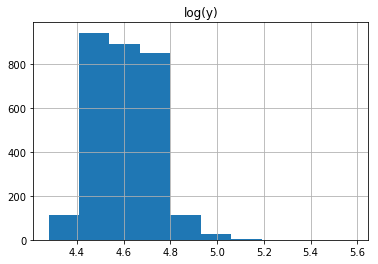

In [31]:
# Check log transform - looks good
%matplotlib inline
train['y'].log().as_data_frame().hist()

# Execute log transform
train['y'] = train['y'].log()
valid['y'] = valid['y'].log()
print(train[0:3, 'y'])

#### Define ranked predictions plot function

In [32]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')


#### Function to generate submission file

In [33]:
import re
import time

def gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['ID'].cbind(preds.exp())
    sub.columns = ['ID', 'y']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple prediction blending function

In [254]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('y', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('ID', axis=1)
        col.columns = ['y' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['ID', 'mean']]
    df.columns = ['ID', 'y']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### Random forest model - typically not tuned as much as GBM

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1498315103371_2


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.006099325457730532
RMSE: 0.07809817832530111
MAE: 0.05341506831481636
RMSLE: 0.013727102548717588
Mean Residual Deviance: 0.006099325457730532

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.008345909946185523
RMSE: 0.09135595189250409
MAE: 0.06707119082087806
RMSLE: 0.016193948450298586
Mean Residual Deviance: 0.008345909946185523

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.006203469204382311
RMSE: 0.07876210512919465
MAE: 0.05415942729203104
RMSLE: 0.013853008058061615
Mean Residual Deviance: 0.006203469204382311
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0541964,0.0010203,0.0559840,0.0524504,0.0541548
mean_residual_deviance,0.0062176,0.0004219,0.0062388,0.0054766,0.0069376
mse,0.0062176,0.0004219,0.0062388,0.0054766,0.0069376
r2,0.5912442,0.0214883,0.5683860,0.634191,0.5711556
residual_deviance,0.0062176,0.0004219,0.0062388,0.0054766,0.0069376
rmse,0.0787607,0.0026836,0.0789859,0.0740040,0.0832921
rmsle,0.0138550,0.0004245,0.0139687,0.0130696,0.0145268


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-24 11:00:26,3 min 27.498 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-24 11:00:27,3 min 27.866 sec,1.0,0.1070559,0.0673236,0.0114610,0.1645033,0.1275306,0.0270613
,2017-06-24 11:00:27,3 min 28.080 sec,2.0,0.0937146,0.0609079,0.0087824,0.1122543,0.0830991,0.0126010
,2017-06-24 11:00:27,3 min 28.310 sec,3.0,0.0878623,0.0588550,0.0077198,0.0959870,0.0686272,0.0092135
,2017-06-24 11:00:28,3 min 28.614 sec,4.0,0.0929458,0.0615151,0.0086389,0.1037147,0.0778156,0.0107567
---,---,---,---,---,---,---,---,---,---
,2017-06-24 11:01:31,4 min 32.490 sec,232.0,0.0780224,0.0533698,0.0060875,0.0906597,0.0664622,0.0082192
,2017-06-24 11:01:32,4 min 32.818 sec,233.0,0.0780765,0.0534082,0.0060959,0.0908477,0.0666435,0.0082533
,2017-06-24 11:01:32,4 min 33.118 sec,234.0,0.0780684,0.0533975,0.0060947,0.0909811,0.0667750,0.0082776
,2017-06-24 11:01:32,4 min 33.422 sec,235.0,0.0780993,0.0534153,0.0060995,0.0911813,0.0669379,0.0083140



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
X0_Tencode|X5_Tencode,699.2246704,1.0,0.1001078
X0_Tencode|X1_Tencode,561.0081177,0.8023288,0.0803194
X0_Tencode|X4_Tencode,493.8989563,0.7063523,0.0707114
X0_Tencode,462.7113037,0.6617491,0.0662462
X8_Tencode|X0_Tencode,428.4444275,0.6127421,0.0613403
---,---,---,---
X_23|X_7,0.0299004,0.0000428,0.0000043
X8_Tencode|X_41,0.0286914,0.0000410,0.0000041
X_32|X1_Tencode,0.0249703,0.0000357,0.0000036
X6_Tencode|X_41,0.0200975,0.0000287,0.0000029



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


y,predict
4.38975,4.51501
4.52081,4.56946
4.84411,4.61671
4.53946,4.47397
4.66438,4.54761
4.4977,4.55822
4.54934,4.61194
4.85351,4.68389
4.68083,4.67003
4.5866,4.62018



drf prediction progress: |████████████████████████████████████████████████| 100%


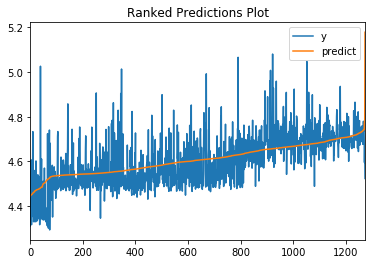

In [35]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=encoded_combined_nums,
    y='y',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
ranked_preds_plot('y', valid, rf_preds1_val) # valid RMSE not so hot ...
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test) #  0.37981 public leaderboard

#### Extremely random trees model - typically not tuned as much as GBM

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1498315103371_3


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.006059447505458417
RMSE: 0.07784245310534874
MAE: 0.05336544997211534
RMSLE: 0.013682738861147903
Mean Residual Deviance: 0.006059447505458417

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.008388277541902042
RMSE: 0.09158754032018789
MAE: 0.06741558857052526
RMSLE: 0.016242258870898942
Mean Residual Deviance: 0.008388277541902042

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.006167873150478721
RMSE: 0.07853580807809087
MAE: 0.05390924982796998
RMSLE: 0.013811408155236344
Mean Residual Deviance: 0.006167873150478721
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0539445,0.0009960,0.0557321,0.0522896,0.0538117
mean_residual_deviance,0.0061815,0.0004084,0.0061971,0.0054665,0.0068811
mse,0.0061815,0.0004084,0.0061971,0.0054665,0.0068811
r2,0.5935950,0.0206596,0.5712674,0.6348681,0.5746495
residual_deviance,0.0061815,0.0004084,0.0061971,0.0054665,0.0068811
rmse,0.0785365,0.0026045,0.0787218,0.0739355,0.0829521
rmsle,0.0138137,0.0004102,0.0139198,0.0130561,0.0144652


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-24 11:07:16,4 min 33.307 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-06-24 11:07:16,4 min 33.669 sec,1.0,0.0965522,0.0679463,0.0093223,0.1612608,0.1250970,0.0260051
,2017-06-24 11:07:16,4 min 33.977 sec,2.0,0.0873187,0.0610241,0.0076246,0.1066890,0.0803861,0.0113825
,2017-06-24 11:07:17,4 min 34.295 sec,3.0,0.0868989,0.0589108,0.0075514,0.0941917,0.0677054,0.0088721
,2017-06-24 11:07:17,4 min 34.621 sec,4.0,0.0908317,0.0615600,0.0082504,0.1063125,0.0790746,0.0113024
---,---,---,---,---,---,---,---,---,---
,2017-06-24 11:08:46,6 min 4.147 sec,269.0,0.0778776,0.0534026,0.0060649,0.0920555,0.0678125,0.0084742
,2017-06-24 11:08:47,6 min 4.467 sec,270.0,0.0778582,0.0533870,0.0060619,0.0919181,0.0677064,0.0084489
,2017-06-24 11:08:47,6 min 4.799 sec,271.0,0.0778491,0.0533825,0.0060605,0.0918060,0.0676055,0.0084283
,2017-06-24 11:08:47,6 min 5.167 sec,272.0,0.0778493,0.0533745,0.0060605,0.0916816,0.0675022,0.0084055



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
X0_Tencode|X5_Tencode,759.7611084,1.0,0.0941377
X0_Tencode|X1_Tencode,723.3890381,0.9521270,0.0896310
X0_Tencode,594.3073120,0.7822292,0.0736373
X0_Tencode|X4_Tencode,501.4489136,0.6600087,0.0621317
X8_Tencode|X0_Tencode,432.3520813,0.5690632,0.0535703
---,---,---,---
X0_Tencode|X_38,0.0528014,0.0000695,0.0000065
X_16|X_15,0.0495693,0.0000652,0.0000061
X_26|X_33,0.0199008,0.0000262,0.0000025
X_21|X_29,0.0071800,0.0000095,0.0000009



See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


y,predict
4.38975,4.51457
4.52081,4.56395
4.84411,4.61712
4.53946,4.47039
4.66438,4.54802
4.4977,4.55654
4.54934,4.61528
4.85351,4.68761
4.68083,4.67214
4.5866,4.62061



drf prediction progress: |████████████████████████████████████████████████| 100%


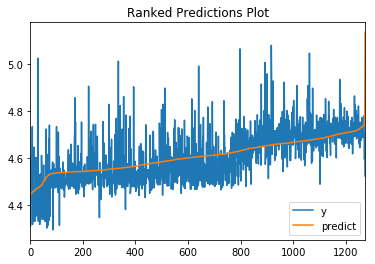

In [36]:
# initialize extra trees model
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=encoded_combined_nums,
    y='y',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('y', valid, ert_preds1_val) # valid RMSE not so hot ...
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) # 0.37403 public leaderboard

#### Train H2O XGBoost - very new!!

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1498315103371_1


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.004132441699741618
RMSE: 0.06428407034204989
MAE: 0.04358157491164247
RMSLE: 0.01126178612017703
Mean Residual Deviance: 0.004132441699741618

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.005877109686661009
RMSE: 0.07666230942686901
MAE: 0.054421233831197374
RMSLE: 0.013565745859951265
Mean Residual Deviance: 0.005877109686661009

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.006242753249283893
RMSE: 0.07901109573524401
MAE: 0.05495024604433564
RMSLE: 0.013904309177924706
Mean Residual Deviance: 0.006242753249283893
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0549937,0.0011280,0.0567787,0.0529066,0.0552958
mean_residual_deviance,0.0062575,0.0004496,0.0062482,0.0054834,0.0070408
mse,0.0062575,0.0004496,0.0062482,0.0054834,0.0070408
r2,0.5887462,0.0225099,0.5677323,0.6337336,0.5647727
residual_deviance,0.0062575,0.0004496,0.0062482,0.0054834,0.0070408
rmse,0.0790019,0.0028463,0.0790457,0.0740502,0.0839097
rmsle,0.0139053,0.0004537,0.0139974,0.0130775,0.0146409


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-24 10:49:07,4 min 52.487 sec,0.0,4.1067835,4.1049322,16.8656709,4.1045675,4.1028785,16.8474747
,2017-06-24 10:49:08,4 min 54.078 sec,1.0,4.0863222,4.0844615,16.6980290,4.0841054,4.0824079,16.6799168
,2017-06-24 10:49:09,4 min 54.123 sec,2.0,4.0659474,4.0640775,16.5319286,4.0637298,4.0620238,16.5139002
,2017-06-24 10:49:09,4 min 54.170 sec,3.0,4.0456946,4.0438152,16.3676445,4.0434761,4.0417616,16.3496993
,2017-06-24 10:49:09,4 min 54.217 sec,4.0,4.0255734,4.0236846,16.2052411,4.0233542,4.0216311,16.1873790
---,---,---,---,---,---,---,---,---,---
,2017-06-24 10:51:50,7 min 35.844 sec,1739.0,0.0649655,0.0439411,0.0042205,0.0764213,0.0541338,0.0058402
,2017-06-24 10:51:54,7 min 39.871 sec,1773.0,0.0648022,0.0438844,0.0041993,0.0764923,0.0542290,0.0058511
,2017-06-24 10:51:58,7 min 43.914 sec,1808.0,0.0646107,0.0437897,0.0041745,0.0765365,0.0542956,0.0058578
,2017-06-24 10:52:02,7 min 47.988 sec,1840.0,0.0644480,0.0436974,0.0041535,0.0765824,0.0543622,0.0058649



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
X0_Tencode|X5_Tencode,295.0,1.0,0.0195119
X8_Tencode|X0_Tencode,111.0,0.3762712,0.0073418
X0_Tencode|X6_Tencode,96.0,0.3254237,0.0063496
X0_Tencode|X1_Tencode,82.0,0.2779661,0.0054236
X0_Tencode|X3_Tencode,62.0,0.2101695,0.0041008
---,---,---,---
X_13|X_35,1.0,0.0033898,0.0000661
X2_Tencode|X_44,1.0,0.0033898,0.0000661
X_19|X2_Tencode,1.0,0.0033898,0.0000661
X2_Tencode|X_14,1.0,0.0033898,0.0000661



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


y,predict
4.38975,4.48808
4.52081,4.59804
4.84411,4.70474
4.53946,4.45947
4.66438,4.55701
4.4977,4.58834
4.54934,4.53155
4.85351,4.73909
4.68083,4.74303
4.5866,4.59347



xgboost prediction progress: |████████████████████████████████████████████| 100%


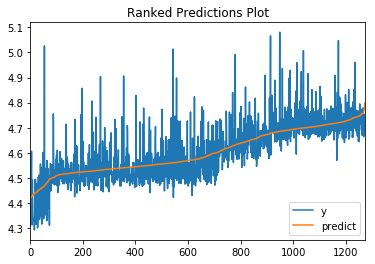

In [34]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='y',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
ranked_preds_plot('y', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) #  on public leaderboard

#### H2O GBM model

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1498315103371_4


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00467367631174996
RMSE: 0.06836429120344889
MAE: 0.046512422996905584
RMSLE: 0.011991119303292792
Mean Residual Deviance: 0.00467367631174996

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.005823892866188283
RMSE: 0.07631443419293812
MAE: 0.05415413906517738
RMSLE: 0.013518045096305813
Mean Residual Deviance: 0.005823892866188283

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.006002129249726298
RMSE: 0.07747340995287542
MAE: 0.05357907822806207
RMSLE: 0.013626688016424965
Mean Residual Deviance: 0.006002129249726298
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0536032,0.0006603,0.0547492,0.0524617,0.0535988
mean_residual_deviance,0.0060142,0.0004102,0.0058965,0.0053699,0.0067762
mse,0.0060142,0.0004102,0.0058965,0.0053699,0.0067762
r2,0.6048394,0.0185112,0.5920686,0.6413194,0.5811304
residual_deviance,0.0060142,0.0004102,0.0058965,0.0053699,0.0067762
rmse,0.0774618,0.0026308,0.0767883,0.0732794,0.0823178
rmsle,0.0136274,0.0004077,0.0135893,0.0129410,0.0143518


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-24 11:20:15,9 min 32.602 sec,0.0,0.1233001,0.1000668,0.0152029,0.1177574,0.0977297,0.0138668
,2017-06-24 11:20:16,9 min 32.958 sec,1.0,0.1228991,0.0996997,0.0151042,0.1174102,0.0974188,0.0137851
,2017-06-24 11:20:16,9 min 33.253 sec,2.0,0.1225041,0.0993292,0.0150072,0.1171067,0.0971041,0.0137140
,2017-06-24 11:20:16,9 min 33.552 sec,3.0,0.1221318,0.0989804,0.0149162,0.1167906,0.0967698,0.0136400
,2017-06-24 11:20:17,9 min 33.861 sec,4.0,0.1217704,0.0986297,0.0148280,0.1164441,0.0964454,0.0135592
---,---,---,---,---,---,---,---,---,---
,2017-06-24 11:23:30,12 min 47.245 sec,666.0,0.0687245,0.0467118,0.0047231,0.0762177,0.0540833,0.0058091
,2017-06-24 11:23:34,12 min 51.487 sec,682.0,0.0685970,0.0466744,0.0047056,0.0762624,0.0541234,0.0058160
,2017-06-24 11:23:38,12 min 55.686 sec,697.0,0.0685060,0.0466084,0.0046931,0.0763015,0.0541583,0.0058219
,2017-06-24 11:23:43,12 min 59.995 sec,714.0,0.0683902,0.0465273,0.0046772,0.0763304,0.0541636,0.0058263



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
X0_Tencode|X1_Tencode,866.1228027,1.0,0.3298715
X0_Tencode|X5_Tencode,706.2370605,0.8154006,0.2689774
X0_Tencode|X6_Tencode,477.6102295,0.5514348,0.1819026
X8_Tencode|X0_Tencode,110.6512833,0.1277547,0.0421426
X0_Tencode|X2_Tencode,71.9049149,0.0830193,0.0273857
---,---,---,---
X_47|X1_Tencode,0.0,0.0,0.0
X2_Tencode|X_12,0.0,0.0,0.0
X2_Tencode|X_11,0.0,0.0,0.0
X_20|X_33,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


y,predict
4.38975,4.48551
4.52081,4.58705
4.84411,4.75945
4.53946,4.46543
4.66438,4.55829
4.4977,4.58827
4.54934,4.57089
4.85351,4.73603
4.68083,4.72334
4.5866,4.63862



gbm prediction progress: |████████████████████████████████████████████████| 100%


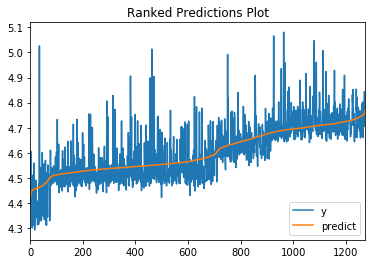

In [37]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=encoded_combined_nums,
                    y='y',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
ranked_preds_plot('y', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission(h2o_gbm_preds1_test) # 0.47948 public leaderboard

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1498315103371_7


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.008994837769471443
RMSE: 0.09484111855873191
MAE: 0.07230166177333863
RMSLE: 0.016793938331914008
Mean Residual Deviance: 0.008994837769471443

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.008797168842338002
RMSE: 0.09379322386152425
MAE: 0.0725923313579232
RMSLE: 0.016672299304396367
Mean Residual Deviance: 0.008797168842338002

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.009306520652538206
RMSE: 0.09647030969442467
MAE: 0.07325213585401244
RMSLE: 0.017087049017341146
Mean Residual Deviance: 0.009306520652538206
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid
mae,0.0732855,0.0019911,0.0742089,0.0691731,0.0727745,0.0769853
mean_residual_deviance,0.0093131,0.0005194,0.0102244,0.0082517,0.0090802,0.0096959
mse,0.0093131,0.0005194,0.0102244,0.0082517,0.0090802,0.0096959
r2,0.3885023,0.0142185,0.3609705,0.4177885,0.3878501,0.3874000
residual_deviance,0.0093131,0.0005194,0.0102244,0.0082517,0.0090802,0.0096959
rmse,0.0964282,0.0027081,0.1011159,0.0908389,0.0952900,0.0984678
rmsle,0.0170806,0.0004622,0.0178410,0.0161114,0.0168937,0.0174762


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-24 12:10:22,12 min 4.264 sec,0.0,0.1233001,0.1000668,0.0152029,0.1177574,0.0977297,0.0138668
,2017-06-24 12:10:22,12 min 4.624 sec,1.0,0.1228951,0.0996960,0.0151032,0.1174067,0.0974157,0.0137843
,2017-06-24 12:10:22,12 min 5.085 sec,2.0,0.1225025,0.0993281,0.0150069,0.1171053,0.0971035,0.0137136
,2017-06-24 12:10:23,12 min 5.385 sec,3.0,0.1221342,0.0989830,0.0149168,0.1167923,0.0967725,0.0136404
,2017-06-24 12:10:23,12 min 5.846 sec,4.0,0.1217800,0.0986393,0.0148304,0.1164527,0.0964546,0.0135612
---,---,---,---,---,---,---,---,---,---
,2017-06-24 12:13:11,14 min 54.148 sec,584.0,0.0948645,0.0723258,0.0089993,0.0938122,0.0726137,0.0088007
,2017-06-24 12:13:15,14 min 58.202 sec,598.0,0.0948573,0.0723184,0.0089979,0.0938070,0.0726076,0.0087998
,2017-06-24 12:13:20,15 min 2.457 sec,613.0,0.0948503,0.0723110,0.0089966,0.0938010,0.0726010,0.0087986
,2017-06-24 12:13:24,15 min 6.718 sec,628.0,0.0948445,0.0723051,0.0089955,0.0937958,0.0725953,0.0087977



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
X0_Tencode|X6_Tencode,2485.2639160,1.0,0.3759082
X0_Tencode|X1_Tencode,2066.3620605,0.8314457,0.3125473
X0_Tencode|X5_Tencode,1573.4097900,0.6330957,0.2379858
X0_Tencode|X4_Tencode,31.7125511,0.0127602,0.0047967
X8_Tencode|X0_Tencode,16.1730289,0.0065076,0.0024462
---,---,---,---
X2_Tencode|X_20,0.0,0.0,0.0
X2_Tencode|X_33,0.0,0.0,0.0
X_23|X1_Tencode,0.0,0.0,0.0
X_7|X_33,0.0,0.0,0.0



See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


y,predict
4.38975,4.55537
4.52081,4.59249
4.84411,4.65764
4.53946,4.53942
4.66438,4.58278
4.4977,4.59011
4.54934,4.58683
4.85351,4.65595
4.68083,4.65297
4.5866,4.61772



gbm prediction progress: |████████████████████████████████████████████████| 100%


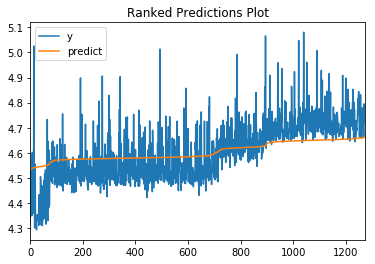

In [40]:
# initialize H2O GBM
h2o_gbm_model2 = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 4,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model2.train(x=encoded_combined_nums,
                    y='y',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model2)
h2o_gbm_preds1_val = h2o_gbm_model2.predict(valid)
ranked_preds_plot('y', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model2.predict(test)
gen_submission(h2o_gbm_preds1_test) # 0.47948 public leaderboard

#### Create blend

In [261]:
# create XGBoost blend
pred_blender('../data',
            ['submission_Fri_Jun_23_23_58_20_2017.csv',
             'submission_Sat_Jun_24_00_17_21_2017.csv',
             'submission_Sat_Jun_24_00_34_11_2017.csv'])
# 0.14705 on public leaderboard

   ID          y0          y1          y2        mean
0   1   94.167192   91.750796   88.628263   91.515417
1   2   94.023250   93.655736   91.952484   93.210490
2   3   78.019170   78.732005   80.247517   78.999564
3   4   78.287904   78.579893   78.252049   78.373282
4   5  105.766781  106.022825  112.087374  107.958994


#### Train H2O stacked ensemble

stackedensemble Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_model_python_1498315103371_5
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.003982272653042696
RMSE: 0.06310525059805004
MAE: 0.043598649923403496
RMSLE: 0.01107224636588909
R^2: 0.738058606788057
Mean Residual Deviance: 0.003982272653042696
Null degrees of freedom: 2935
Residual degrees of freedom: 2933
Null deviance: 44.63575751041223
Residual deviance: 11.691952509333355
AIC: -7884.04297925371

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.006127261751288883
RMSE: 0.07827682767772902
MAE: 0.055526112562959265
RMSLE: 0.013867053202579853
R^2: 0.5580002911095605
Mean Residual Deviance: 0.006127261751288883
Null degrees of freedom: 1272
Residual degrees of freedom: 1270
Null deviance: 17.65244879066259
Residual 

y,predict
4.38975,4.4875
4.52081,4.57671
4.84411,4.71788
4.53946,4.45829
4.66438,4.55079
4.4977,4.57509
4.54934,4.58242
4.85351,4.72482
4.68083,4.71055
4.5866,4.63264



stackedensemble prediction progress: |████████████████████████████████████| 100%


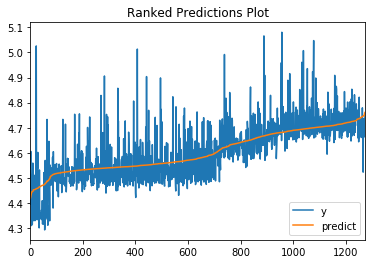

In [38]:
stack = H2OStackedEnsembleEstimator(training_frame=train, 
                                    validation_frame=valid, 
                                    base_models=[rf_model1, ert_model1, 
                                                 h2o_gbm_model])

stack.train(x=encoded_combined_nums,
            y='y',
            training_frame=train,
            validation_frame=valid)

# print model information/create submission
print(stack)
stack_preds1_val = stack.predict(valid)
ranked_preds_plot('y', valid, stack_preds1_val) 
stack_preds1_test = stack.predict(test)
gen_submission(stack_preds1_test)
# 0.14630 on public leaderboard

#### Native XGBoost GBM model (for example)

[0]	train-rmse:0.394481	eval-rmse:0.386675
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.392907	eval-rmse:0.385508
[2]	train-rmse:0.391742	eval-rmse:0.384175
[3]	train-rmse:0.390294	eval-rmse:0.382704
[4]	train-rmse:0.388924	eval-rmse:0.381541
[5]	train-rmse:0.387633	eval-rmse:0.380214
[6]	train-rmse:0.386467	eval-rmse:0.379089
[7]	train-rmse:0.385057	eval-rmse:0.377412
[8]	train-rmse:0.383782	eval-rmse:0.376077
[9]	train-rmse:0.382354	eval-rmse:0.374844
[10]	train-rmse:0.381072	eval-rmse:0.373659
[11]	train-rmse:0.379447	eval-rmse:0.372006
[12]	train-rmse:0.377973	eval-rmse:0.370835
[13]	train-rmse:0.376468	eval-rmse:0.369565
[14]	train-rmse:0.374766	eval-rmse:0.368023
[15]	train-rmse:0.373482	eval-rmse:0.366748
[16]	train-rmse:0.372088	eval-rmse:0.365415
[17]	train-rmse:0.370921	eval-rmse:0.364812
[18]	train-rmse:0.369993	eval-rmse:0.364129
[19]	train-rmse:0.36835	eval-rm

SalePrice,predict
11.8494,12.062
12.2061,12.306
11.6784,11.6806
11.914,11.7686
12.6758,12.487
12.861,12.5802
12.1035,11.9194
11.2898,11.4222
11.7714,11.6392
11.5843,11.6461



Parse progress: |█████████████████████████████████████████████████████████| 100%


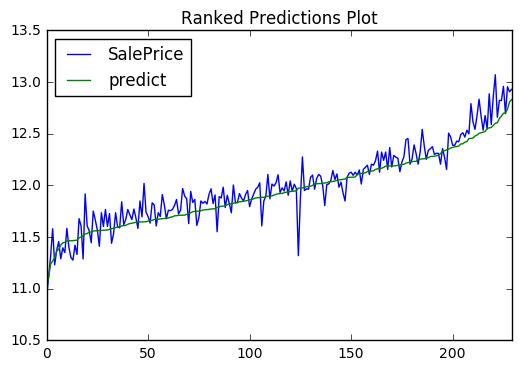

In [107]:
"""

ave_y = half_train['SalePrice'].mean()[0]

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain1 = xgb.DMatrix(train.as_data_frame()[encoded_combined_nums],
                      train.as_data_frame()['SalePrice'])
dvalid1 = xgb.DMatrix(valid.as_data_frame()[encoded_combined_nums],
                      valid.as_data_frame()['SalePrice'])
dtest = xgb.DMatrix(test.as_data_frame()[encoded_combined_nums])

# tuning parameters
params1 = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.005,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'reg_alpha' : 0.007,
    'reg_lambda' : 0.0,
    'base_score': ave_y,
    'silent': 0,
    'seed': 12345,
}

# watchlist is used for early stopping
watchlist = [(dtrain1, 'train'), (dvalid1, 'eval')]

# train model
xgb_model1 = xgb.train(params1, 
                       dtrain1, 
                       10000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)

# create assessment stats and submission file
xgb_preds1_val = h2o.H2OFrame(xgb_model1.predict(dvalid1).tolist())
ranked_preds_plot('SalePrice', valid, xgb_preds1_val) 
xgb_preds1_test = h2o.H2OFrame(xgb_model1.predict(dtest).tolist())
gen_submission(xgb_preds1_test) 

"""

#### Shutdown H2O

In [122]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_942e closed.
